In [1]:
from minimal_model import insulin_clamp_dynamic, ref_parameters, TAU_INS, equation, fluxes, REF_STEADY_STATE_VALUES
import numpy as np
import pandas as pd 

In [2]:
# Compute ref insulin value
k = 3.4
C = 2.3
I0 = abs(1.0)**k / (abs(1.0)**k + C**k)

In [3]:
time = np.arange(0,130,10)
N = len(time)

vI_low = I0/TAU_INS # Double basal fasted insulin levles
vI_high = I0/TAU_INS * 3 # Two time low dose

In [4]:
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 

# GIR scaling 
sGIR = vE * 180 * 1e-3

# Infusion rates for the perurbative infusions 

# Intralipid // based on Fatty acid oxidation 
# Fit this to the data
# v_in_F = 0.0056 * 1.5

# 3HB 
v_in_K = 120/vE

# Lactate
v_in_L = 130.5/vE 

In [5]:
# Load all the experimental data

# Glucose infusion rate
GIR_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

GIR_clamp_3HB = pd.read_csv('data/3HB_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

GIR_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_GIR.csv',index_col=0) \
                            .melt(ignore_index=False).reset_index()\
                            .rename(columns={'index':'time', 'value':'GIR'}).dropna()

# Fatty acids 
FFA_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_FFA.csv', index_col=0)\
                        .melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'Species', 'value':'FFA'})

FFA_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_FFA.csv', index_col=0)\
                        .melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'Species', 'value':'FFA'})

# 3HB and lactate
_3HB_clamp_3HB = pd.read_csv('data/3HB_clamp_insulin_dose_3HB.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'3HB'})
lactate_clamp_lactate = pd.read_csv('data/Lactate_clamp_insulin_dose_lactate.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'lactate'})
lactate_clamp_intralipid = pd.read_csv('data/Intralipid_clamp_insulin_dose_lactate.csv', index_col=0).melt(ignore_index=False).dropna().reset_index().rename(columns={'index':'time', 'value':'lactate'})

# Clean up variable names
dataframes = [GIR_clamp_intralipid, GIR_clamp_3HB, GIR_clamp_lactate, FFA_clamp_intralipid, FFA_clamp_lactate, _3HB_clamp_3HB, lactate_clamp_lactate]

for df in dataframes:
    # Remove trailing ".number" from variable names
    df.loc[:,'variable'] = df.loc[:,'variable'].str.replace(r'\.\d+$','')


# Combine the dataframes in a named dict
data = {
    'GIR_clamp_intralipid': GIR_clamp_intralipid,
    'GIR_clamp_3HB': GIR_clamp_3HB,
    'GIR_clamp_lactate': GIR_clamp_lactate,
    'FFA_clamp_intralipid': FFA_clamp_intralipid,
    '3HB_clamp_3HB': _3HB_clamp_3HB,
    'lactate_clamp_lactate': lactate_clamp_lactate,
    'FFA_clamp_lactate': FFA_clamp_lactate,
    'lactate_clamp_intralipid': lactate_clamp_intralipid,
}

# Scale the GIR into simulation units
for key in data.keys():
    if 'GIR' in key:
        data[key].loc[:,'GIR'] = data[key].loc[:,'GIR'] / sGIR
        # Print mean and std of the GIR
        print(f"{key} mean: {data[key].GIR.mean()} std: {data[key].GIR.std()} max: {data[key].GIR.max()}")

GIR_clamp_intralipid mean: 0.01613207799145299 std: 0.011936617643019615 max: 0.04289682539682539
GIR_clamp_3HB mean: 0.015605250305250305 std: 0.012674530599339756 max: 0.04289682539682539
GIR_clamp_lactate mean: 0.014037815126050419 std: 0.012432624037613789 max: 0.04289682539682539


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_38821/202027615.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:,'variable'] = df.loc[:,'variable'].str.replace(r'\.\d+$','')


In [6]:
GIR_clamp_intralipid

,time,variable,GIR
0,0,Saline,0.000000
1,10,Saline,0.000000
2,20,Saline,0.000000
3,30,Saline,0.000000
4,40,Saline,0.000000
...,...,...,...
814,80,1.25 mU Insulin + Intralipid,0.007151
815,90,1.25 mU Insulin + Intralipid,0.007151
816,100,1.25 mU Insulin + Intralipid,0.007151
817,110,1.25 mU Insulin + Intralipid,0.007151


<Axes: xlabel='time', ylabel='GIR'>

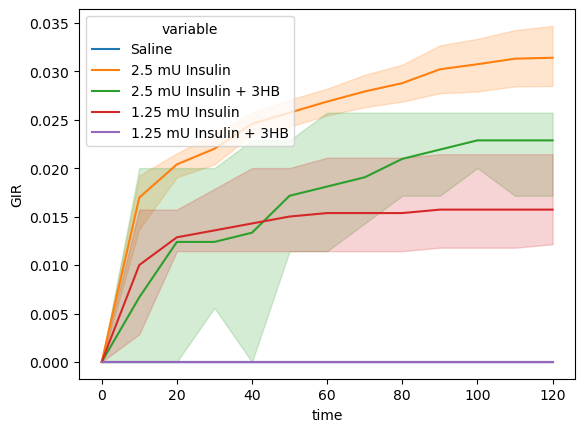

In [7]:
import seaborn as sns
sns.lineplot(data['GIR_clamp_3HB'], x='time', y='GIR', hue='variable')

In [8]:
# Normlize the concentrations to saline 
data['3HB_clamp_3HB'].loc[:,'3HB'] = data['3HB_clamp_3HB'].loc[:,'3HB']\
    /data['3HB_clamp_3HB'].query("variable == 'Saline'")['3HB'].mean()

data['lactate_clamp_lactate'].loc[:,'lactate'] = data['lactate_clamp_lactate'].loc[:,'lactate']\
    /data['lactate_clamp_lactate'].query("variable == 'Saline'")['lactate'].mean()

data['FFA_clamp_intralipid'].loc[:,'FFA'] = data['FFA_clamp_intralipid'].loc[:,'FFA']\
    /data['FFA_clamp_intralipid'].query("variable == 'Saline'")['FFA'].mean()

data['FFA_clamp_lactate'].loc[:,'FFA'] = data['FFA_clamp_lactate'].loc[:,'FFA']\
    /data['FFA_clamp_lactate'].query("variable == 'Saline'")['FFA'].mean()

data['lactate_clamp_intralipid'].loc[:,'lactate'] = data['lactate_clamp_intralipid'].loc[:,'lactate']\
    /data['lactate_clamp_intralipid'].query("variable == 'Saline'")['lactate'].mean()

In [9]:
data['lactate_clamp_intralipid']

,time,variable,lactate
0,0,Saline,1.378788
1,10,Saline,0.787879
2,20,Saline,0.984848
3,30,Saline,0.984848
4,40,Saline,1.181818
...,...,...,...
260,80,1.25 mU Insulin + Intralipid.2,1.181818
261,90,1.25 mU Insulin + Intralipid.2,1.181818
262,100,1.25 mU Insulin + Intralipid.2,1.378788
263,110,1.25 mU Insulin + Intralipid.2,1.181818


In [10]:
x_insulin_low_3HB, GIR_insulin_low_3HB = insulin_clamp_dynamic(vI_low, time, 1,v_in_K=v_in_K)

# Substrate fluxes GIR from GIR column matiching time 
temp = data['GIR_clamp_3HB'].query("variable == '1.25 mU Insulin + 3HB'")\
            .merge(GIR_insulin_low_3HB, on='time', how='inner')
res = temp['GIR_x'] - temp['GIR_y']

res = data['3HB_clamp_3HB'].query("variable == '1.25 mU Insulin + 3HB'")['3HB'] - x_insulin_low_3HB.loc[N-1,'K']

In [11]:
def residual_function(params,data):
    
    # Allow only positive parameters
    KI_lipo,  KA_glut4, KA_glut4_GL, KI_GY, KIL, KIK, KF, KG, KFK, KL, KI_F = 10**params[:-1]
    v_in_F = abs(params[-1])

    # Recompute constrainted parameter values 
    p = ref_parameters( KI_lipo,  KA_glut4, KA_glut4_GL, KI_GY, KIL, KIK, KF, KG, KFK, KL, KI_F,)

    # Compute all the clamp model predicitons
    x_insulin_low, GIR_insulin_low = insulin_clamp_dynamic(vI_low, time, 1, p=p)
    x_insulin_high, GIR_insulin_high = insulin_clamp_dynamic(vI_high, time, 1, p=p)

    x_insulin_low_intralipid, GIR_insulin_low_intralipid = insulin_clamp_dynamic(vI_low, time,1,p=p, v_in_F=v_in_F)
    x_insulin_high_intralipid, GIR_insulin_high_intralipid = insulin_clamp_dynamic(vI_high, time,1,p=p, v_in_F=v_in_F)

    x_insulin_low_3HB, GIR_insulin_low_3HB = insulin_clamp_dynamic(vI_low, time, 1,v_in_K=v_in_K, p=p)
    x_insulin_high_3HB, GIR_insulin_high_3HB = insulin_clamp_dynamic(vI_high, time,1, v_in_K=v_in_K, p=p)

    x_insulin_low_lactate, GIR_insulin_low_lactate = insulin_clamp_dynamic(vI_low, time,1,v_in_L=v_in_L, p=p)
    x_insulin_high_lactate, GIR_insulin_high_lactate = insulin_clamp_dynamic(vI_high, time,1, v_in_L=v_in_L, p=p)


    residuals = []

    # Compute residuals of glucose infusion rate for each time point 
    # GIR Scale # based on max GIR
    gir_scale = sGIR / 10 

    # Low insulin
    temp = data['GIR_clamp_intralipid'].query("variable == '1.25 mU Insulin'")\
            .merge(GIR_insulin_low, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale)   

    # High insulin
    temp = data['GIR_clamp_intralipid'].query("variable == '2.5 mU Insulin'")\
                    .merge(GIR_insulin_high, on='time', how='inner')
    res = (temp['GIR_x'] - temp['GIR_y']) 
    residuals.append(res * gir_scale)

    # Intralipid - low insulin
    temp = data['GIR_clamp_intralipid'].query("variable == '1.25 mU Insulin + Intralipid'")\
                .merge(GIR_insulin_low_intralipid, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale )

    # Intralipid - high insulin
    temp = data['GIR_clamp_intralipid'].query("variable == '2.5 mU Insulin + Intralipid'")\
                     .merge(GIR_insulin_high_intralipid, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale)

    # 3HB - low insulin
    temp = data['GIR_clamp_3HB'].query("variable == '1.25 mU Insulin + 3HB'")\
                    .merge(GIR_insulin_low_3HB, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale)

    # 3HB - high insulin
    temp = data['GIR_clamp_3HB'].query("variable == '2.5 mU Insulin + 3HB'")\
                   .merge(GIR_insulin_high_3HB, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale)

    # Lactate - low insulin
    temp = data['GIR_clamp_lactate'].query("variable == '1.25 mU Insulin + Lactate'")\
                    .merge(GIR_insulin_low_lactate, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale)

    # Lactate - high insulin
    temp = data['GIR_clamp_lactate'].query("variable == '2.5 mU Insulin + Lactate'")\
                    .merge(GIR_insulin_high_lactate, on='time', how='inner')
    res = temp['GIR_x'] - temp['GIR_y']
    residuals.append(res * gir_scale)

    # Compute the residuals for concentrations at steady state

    # Insulin - low insulin
    res = data['FFA_clamp_intralipid'].query("variable == '1.25 mU Insulin'")['FFA'] - x_insulin_low.loc[N-1,'F']
    residuals.append(res)

    res = data['3HB_clamp_3HB'].query("variable == '1.25 mU Insulin'")['3HB'] - x_insulin_low.loc[N-1,'K']
    residuals.append(res)

    res = data['lactate_clamp_lactate'].query("variable == '1.25 mU Insulin'")['lactate'] - x_insulin_low.loc[N-1,'L']
    residuals.append(res)

    # Insulin - high insulin
    res = data['FFA_clamp_intralipid'].query("variable == '2.5 mU Insulin'")['FFA'] - x_insulin_high.loc[N-1,'F']
    residuals.append(res)
    
    res = data['3HB_clamp_3HB'].query("variable == '2.5 mU Insulin'")['3HB'] - x_insulin_high.loc[N-1,'K']
    residuals.append(res)
    
    res = data['lactate_clamp_lactate'].query("variable == '2.5 mU Insulin'")['lactate'] - x_insulin_high.loc[N-1,'L']
    residuals.append(res)

    # Intralipid - low insulin
    res = data['FFA_clamp_intralipid'].query("variable == '1.25 mU Insulin + Intralipid'")['FFA'] - x_insulin_low_intralipid.loc[N-1,'F']
    residuals.append(res)

    res = data['lactate_clamp_intralipid'].query("variable == '1.25 mU Insulin + Intralipid'")['lactate'] - x_insulin_low_intralipid.loc[N-1,'L']
    residuals.append(res)

     # Intralipid - high insulin
    res = data['FFA_clamp_intralipid'].query("variable == '2.5 mU Insulin + Intralipid'")['FFA'] - x_insulin_high_intralipid.loc[N-1,'F']
    residuals.append(res)

    # 3HB - low insulin
    res = data['3HB_clamp_3HB'].query("variable == '1.25 mU Insulin + 3HB'")['3HB'] - x_insulin_low_3HB.loc[N-1,'K']
    residuals.append(res)   

     # 3HB - high insulin
    res = data['3HB_clamp_3HB'].query("variable == '2.5 mU Insulin + 3HB'")['3HB'] - x_insulin_high_3HB.loc[N-1,'K']
    residuals.append(res)
    
    # Lactate - low insulin
    res = data['lactate_clamp_lactate'].query("variable == '1.25 mU Insulin + Lactate'")['lactate'] - x_insulin_low_lactate.loc[N-1,'L']
    residuals.append(res)

    res = data['FFA_clamp_lactate'].query("variable == '1.25 mU Insulin + Lactate'")['FFA'] - x_insulin_low_lactate.loc[N-1,'F']
    residuals.append(res)

     # Lactate - high insulin
    res = data['lactate_clamp_lactate'].query("variable == '2.5 mU Insulin + Lactate'")['lactate'] - x_insulin_high_lactate.loc[N-1,'L']
    residuals.append(res)
    
    return np.concatenate(residuals)






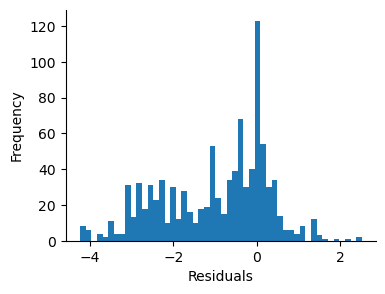

In [12]:
# Test the residual function
p0 = np.zeros(12)

import matplotlib.pyplot as plt 
import seaborn as sns

# Risiduals from the initial guess
f, ax = plt.subplots(1,1, figsize=(4,3))
plt.hist(residual_function(p0,data), bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

sns.despine()


In [13]:
from scipy.optimize import least_squares

bounds = [(-3, 3)] * 12
bounds[-1] = (0,0.1)

# convert from [[], []] to [], []
bounds = list(zip(*bounds))

p0[-1] = 0.0056 # ~Fatty acid oxidation
res_robust = least_squares(residual_function, p0, loss='soft_l1', f_scale=2.0, bounds=bounds,
                           args=(data,), verbose=2)

res_robust

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         7.4388e+02                                    1.75e+03    
       1              2         7.0853e+02      3.53e+01       2.63e-02       5.64e+02    
       2              3         7.0159e+02      6.95e+00       6.17e-02       2.91e+01    
       3              4         7.0043e+02      1.15e+00       1.24e-01       2.74e+01    
       4              5         6.9871e+02      1.73e+00       2.43e-01       1.17e+01    
       5              6         6.9696e+02      1.75e+00       4.65e-01       4.81e+01    
       6              7         6.9667e+02      2.88e-01       1.05e-01       3.61e+00    
       7              8         6.9635e+02      3.17e-01       2.05e-01       2.18e+00    
       8              9         6.9603e+02      3.19e-01       3.88e-01       1.71e+00    
       9             14         6.9603e+02      1.03e-03       2.67e-03       4.76e-01    

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 0.000e+00  0.000e+00 ...  1.083e-01 -3.559e-01]
           x: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                5.013e-18  9.735e-16  0.000e+00  0.000e+00  0.000e+00
               -1.622e+00  1.124e-02]
        cost: 696.0304592282212
         jac: [[ 0.000e+00  0.000e+00 ... -0.000e+00  0.000e+00]
               [ 0.000e+00  0.000e+00 ... -0.000e+00  0.000e+00]
               ...
               [ 0.000e+00  0.000e+00 ... -2.717e-03  0.000e+00]
               [ 0.000e+00  0.000e+00 ... -2.660e-03  0.000e+00]]
        grad: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
                0.000e+00  0.000e+00  0.000e+00  0.000e+00  0.000e+00
               -1.181e+00  2.647e+00]
  optimality: 5.458781518848798
 active_mask: [0 0 0 0 0 0 0 0 0 0 0 0]
        nfev: 25
        njev: 11

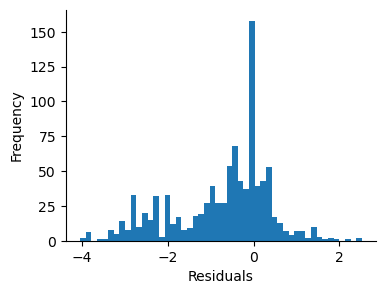

In [14]:
# Risiduals from the resulst guess
f, ax = plt.subplots(1,1, figsize=(4,3))
plt.hist(residual_function(res_robust.x,data), bins=50)
plt.xlabel('Residuals')
plt.ylabel('Frequency')

sns.despine()

In [15]:
# Allow only positive parameters
KI_lipo,  KA_glut4, KA_glut_GL, KI_GL, KIL, KIK, KF, KG, KFK, KL, KI_F = 10**res_robust.x[:-1]
v_in_F = abs(res_robust.x[-1])

# Recompute constrainted parameter values 
p_test = ref_parameters( KI_lipo,  KA_glut4, KA_glut_GL, KI_GL, KIL, KIK, KF, KG, KFK, KL, KI_F,)

In [16]:
# Print the parameters to the screen
print(f"KI_lipo = {KI_lipo}")
print(f"KA_glut4 = {KA_glut4}")
print(f"KA_glut_GL = {KA_glut_GL}")
print(f"KI_GL = {KI_GL}")
print(f"KIL = {KIL}")
print(f"KIK = {KIK}")
print(f"KF = {KF}")
print(f"KG = {KG}")
print(f"KFK = {KFK}")
print(f"KL = {KL}")
print(f"KI_F = {KI_F}")

# Fin 
print(f"v_in_F = {v_in_F}")


KI_lipo = 1.0
KA_glut4 = 1.0
KA_glut_GL = 1.0
KI_GL = 1.0
KIL = 1.0
KIK = 1.0
KF = 1.0000000000000022
KG = 1.0
KFK = 1.0
KL = 1.0
KI_F = 0.023877450482079586
v_in_F = 0.0112422322540602


In [17]:
time = np.linspace(0,120,120)
x_insulin_low, GIR_insulin_low = insulin_clamp_dynamic(vI_low, time, 1,p = p_test)
x_insulin_high, GIR_insulin_high = insulin_clamp_dynamic(vI_high, time, 1,p = p_test)

# With Intralipid
x_insulin_low_intralipid, GIR_insulin_low_intralipid = insulin_clamp_dynamic(vI_low, time,1,p = p_test, v_in_F=v_in_F)


In [18]:
# scale the GIR by sGIR
GIR_insulin_low.loc[:,'GIR'] = GIR_insulin_low.loc[:,'GIR'] * sGIR
GIR_insulin_high.loc[:,'GIR'] = GIR_insulin_high.loc[:,'GIR'] * sGIR
GIR_insulin_low_intralipid.loc[:,'GIR'] = GIR_insulin_low_intralipid.loc[:,'GIR'] * sGIR

<Axes: xlabel='time'>

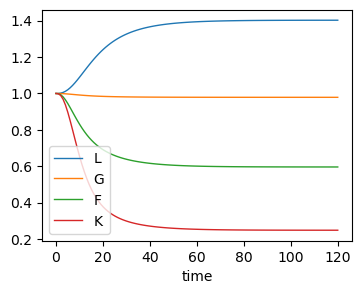

In [19]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,1, figsize=(4,3))

x_insulin_low.plot(x='time', y='L', label='L', linewidth=1, ax=ax)
x_insulin_low.plot(x='time', y='G', label='G', linewidth=1, ax=ax)
x_insulin_low.plot(x='time', y='F', label='F', linewidth=1, ax=ax)
x_insulin_low.plot(x='time', y='K', label='K', linewidth=1, ax=ax)


<Axes: xlabel='time'>

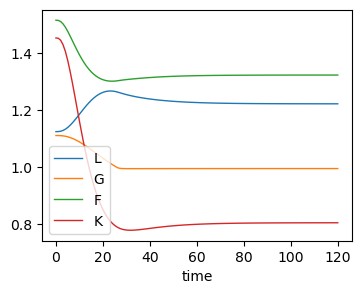

In [20]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

x_insulin_low_intralipid.plot(x='time', y='L', label='L', linewidth=1, ax=ax)
x_insulin_low_intralipid.plot(x='time', y='G', label='G', linewidth=1, ax=ax)
x_insulin_low_intralipid.plot(x='time', y='F', label='F', linewidth=1, ax=ax)
x_insulin_low_intralipid.plot(x='time', y='K', label='K', linewidth=1, ax=ax)


<Axes: xlabel='time'>

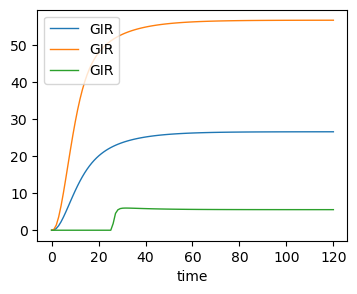

In [21]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

GIR_insulin_low.plot(x='time', y='GIR', label='GIR', linewidth=1, ax=ax)
GIR_insulin_high.plot(x='time', y='GIR', label='GIR', linewidth=1, ax=ax)
GIR_insulin_low_intralipid.plot(x='time', y='GIR', label='GIR', linewidth=1, ax=ax)
